### Imports

In [8]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import sys
sys.path.append('../artifacts')

### Loading Images and coverting Numpy

In [12]:
# Load Real and Recon Images
real_img = Image.open('../artifact/real.JPEG').convert('RGB')
recon_img = Image.open('../artifact/recon.JPEG').convert('RGB')
real_rgb = np.array(real_img).astype(np.float32) / 255.00
recon_rgb = np.array(recon_img).astype(np.float32) / 255.00

In [27]:
# convert numpy into tensors
real_tensor = torch.from_numpy(real_rgb).permute(2, 0, 1) * 2.0 - 1.0   # [3, H, W]
recon_tensor = torch.from_numpy(recon_rgb).permute(2, 0, 1) * 2.0 - 1.0  # [3, H, W]

_, H, W = real_tensor.shape

In [28]:
real_tensor.shape, recon_tensor.shape

(torch.Size([3, 263, 350]), torch.Size([3, 263, 350]))

### Patch-swap function

In [29]:
def patch_swap_with_heatmap(recon_img, real_img, patch_size=96, num_patches=8, seed=123):
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)
    
    patched_recon = recon_img.clone()
    
    # Create a heatmap to track swap intensity (higher = more overlaps)
    heatmap = torch.zeros(H, W)
    
    swap_locations = []  # optional: store exact patch coords
    
    for _ in range(num_patches):
        i = torch.randint(0, H - patch_size + 1, (1,)).item()
        j = torch.randint(0, W - patch_size + 1, (1,)).item()
        
        # Swap: copy patch from real into recon
        patch_from_real = real_img[:, i:i+patch_size, j:j+patch_size]
        patched_recon[:, i:i+patch_size, j:j+patch_size] = patch_from_real
        
        # Update heatmap: add 1 to the swapped region
        heatmap[i:i+patch_size, j:j+patch_size] += 1
        
        swap_locations.append((i, j, patch_size))
    
    return patched_recon, heatmap, swap_locations

In [30]:
patched_recon, swap_heatmap, locations = patch_swap_with_heatmap(
    recon_tensor, real_tensor, 
    patch_size=96, 
    num_patches=10, 
    seed=42
)

In [31]:
# Apply patch swap
def denorm(tensor):
    return ((tensor.clamp(-1, 1) + 1) / 2).permute(1, 2, 0).cpu().numpy()

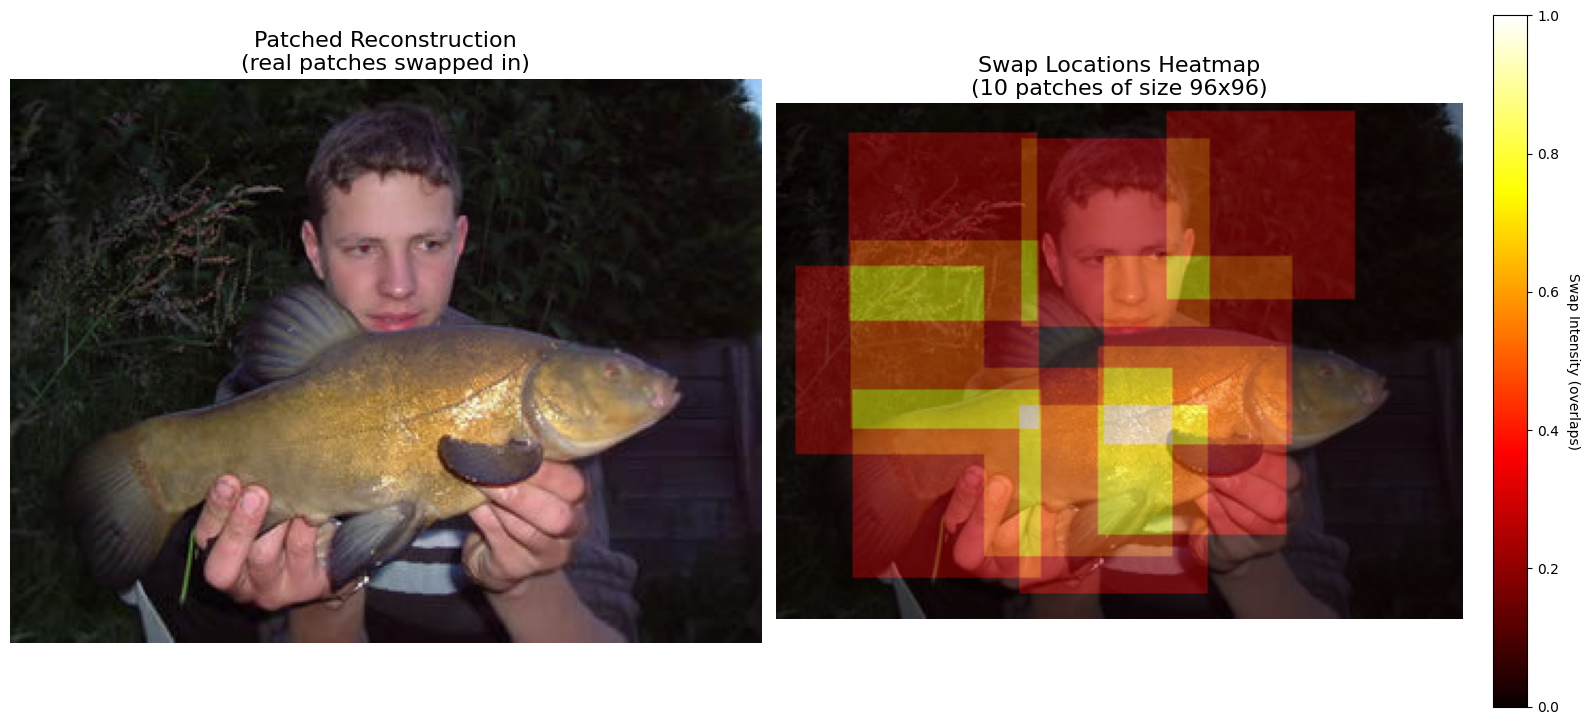

Swap patch locations (top-left corner, size):
  Patch 1: top-left (78, 167), size 96x96
  Patch 2: top-left (4, 199), size 96x96
  Patch 3: top-left (18, 125), size 96x96
  Patch 4: top-left (124, 164), size 96x96
  Patch 5: top-left (70, 38), size 96x96
  Patch 6: top-left (154, 124), size 96x96
  Patch 7: top-left (146, 39), size 96x96
  Patch 8: top-left (15, 37), size 96x96
  Patch 9: top-left (83, 10), size 96x96
  Patch 10: top-left (135, 106), size 96x96


In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Left: Patched Reconstruction
ax1.imshow(denorm(patched_recon))
ax1.set_title("Patched Reconstruction\n(real patches swapped in)", fontsize=16)
ax1.axis('off')

# Right: Heatmap overlay on the patched image
img = denorm(patched_recon)
heatmap_np = swap_heatmap.cpu().numpy()
heatmap_normalized = heatmap_np / heatmap_np.max()  # normalize for visibility

ax2.imshow(img)
ax2.imshow(heatmap_normalized, cmap='hot', alpha=0.5, interpolation='bilinear')
ax2.set_title(f"Swap Locations Heatmap\n({len(locations)} patches of size {96}x{96})", fontsize=16)
ax2.axis('off')

# Optional: add colorbar
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='hot'), ax=ax2, fraction=0.046, pad=0.04)
cbar.set_label('Swap Intensity (overlaps)', rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

# Bonus: print where swaps happened
print("Swap patch locations (top-left corner, size):")
for idx, (i, j, size) in enumerate(locations):
    print(f"  Patch {idx+1}: top-left ({i}, {j}), size {size}x{size}")

Performing 152 random 4x4 patch swaps from real → reconstruction


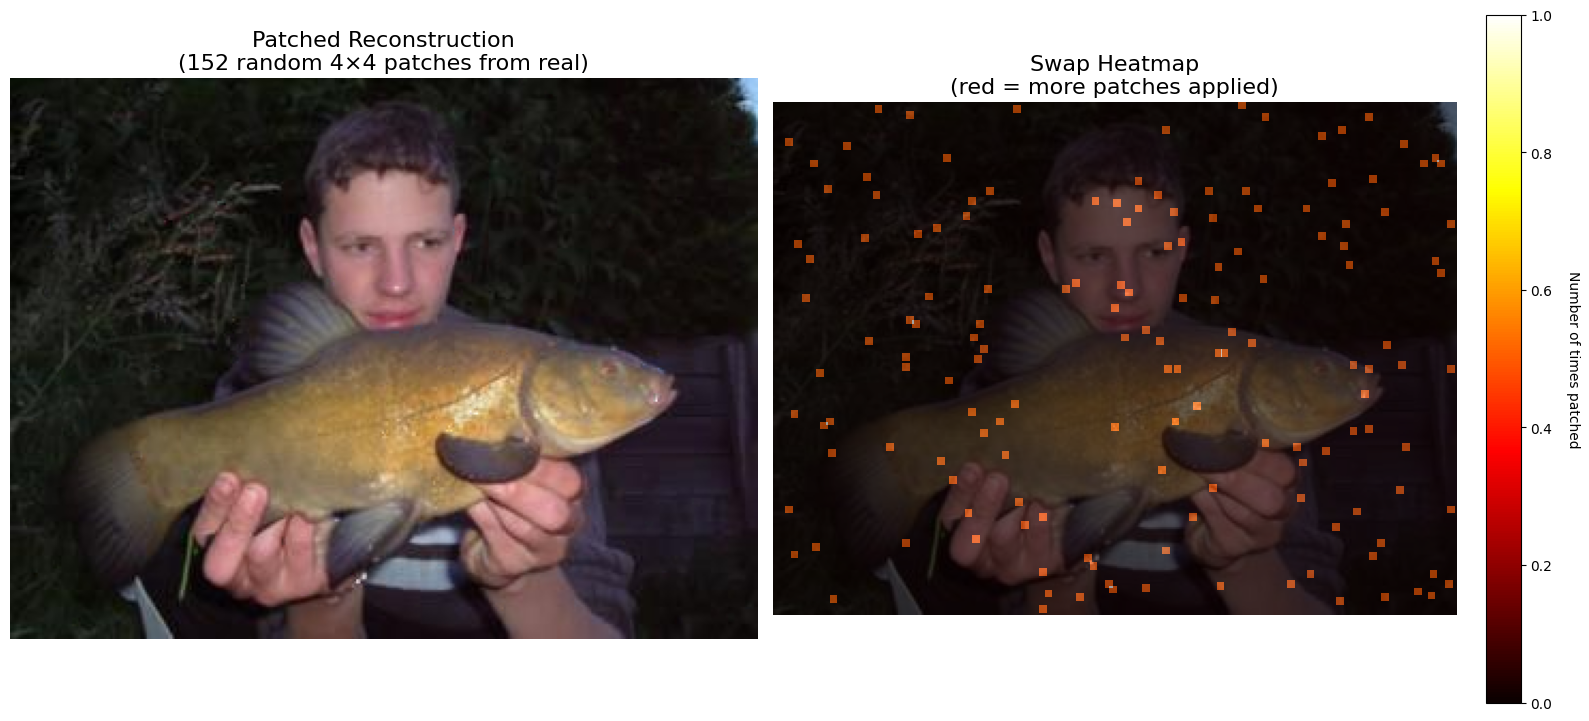

In [34]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Convert to PyTorch tensors [-1, 1]
real_tensor = torch.from_numpy(real_rgb).permute(2, 0, 1) * 2.0 - 1.0   # [3, H, W]
recon_tensor = torch.from_numpy(recon_rgb).permute(2, 0, 1) * 2.0 - 1.0  # [3, H, W]

_, H, W = real_tensor.shape

# Settings
patch_size = 4                  # 4x4 patches
max_swaps = 300                 # maximum possible swaps (feel free to increase)
min_swaps = 50                  # minimum swaps (optional, set to 1 if you want)

# Random number of swaps
num_swaps = np.random.randint(min_swaps, max_swaps + 1)
print(f"Performing {num_swaps} random 4x4 patch swaps from real → reconstruction")

# Set seed if you want reproducible results (remove or change for true randomness)
# torch.manual_seed(123)
# np.random.seed(123)

patched_recon = recon_tensor.clone()

# Heatmap to track how many times each pixel was patched
heatmap = torch.zeros(H, W)

# Perform random swaps
for _ in range(num_swaps):
    # Random top-left corner (must fit 4x4 patch)
    i = torch.randint(0, H - patch_size + 1, (1,)).item()
    j = torch.randint(0, W - patch_size + 1, (1,)).item()
    
    # Copy 4x4 patch from real to recon
    patched_recon[:, i:i+patch_size, j:j+patch_size] = real_tensor[:, i:i+patch_size, j:j+patch_size]
    
    # Mark in heatmap
    heatmap[i:i+patch_size, j:j+patch_size] += 1

# -----------------------------
# Visualization
# -----------------------------
def denorm(t):
    return ((t.clamp(-1, 1) + 1) / 2).permute(1, 2, 0).cpu().numpy()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Left: Patched Reconstruction
ax1.imshow(denorm(patched_recon))
ax1.set_title(f"Patched Reconstruction\n({num_swaps} random 4×4 patches from real)", fontsize=16)
ax1.axis('off')

# Right: Heatmap overlay
img = denorm(patched_recon)
heatmap_np = heatmap.cpu().numpy()
if heatmap_np.max() > 0:
    heatmap_norm = heatmap_np / heatmap_np.max()
else:
    heatmap_norm = heatmap_np

ax2.imshow(img)
ax2.imshow(heatmap_norm, cmap='hot', alpha=0.6, interpolation='nearest')
ax2.set_title(f"Swap Heatmap\n(red = more patches applied)", fontsize=16)
ax2.axis('off')

# Colorbar
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='hot'), ax=ax2, fraction=0.046, pad=0.04)
cbar.set_label('Number of times patched', rotation=270, labelpad=20)

plt.tight_layout()
plt.show()

Image size: 263×350 → Patch size: 32×32 (1/8)
Applying 112 random 32×32 patches from real → reconstruction


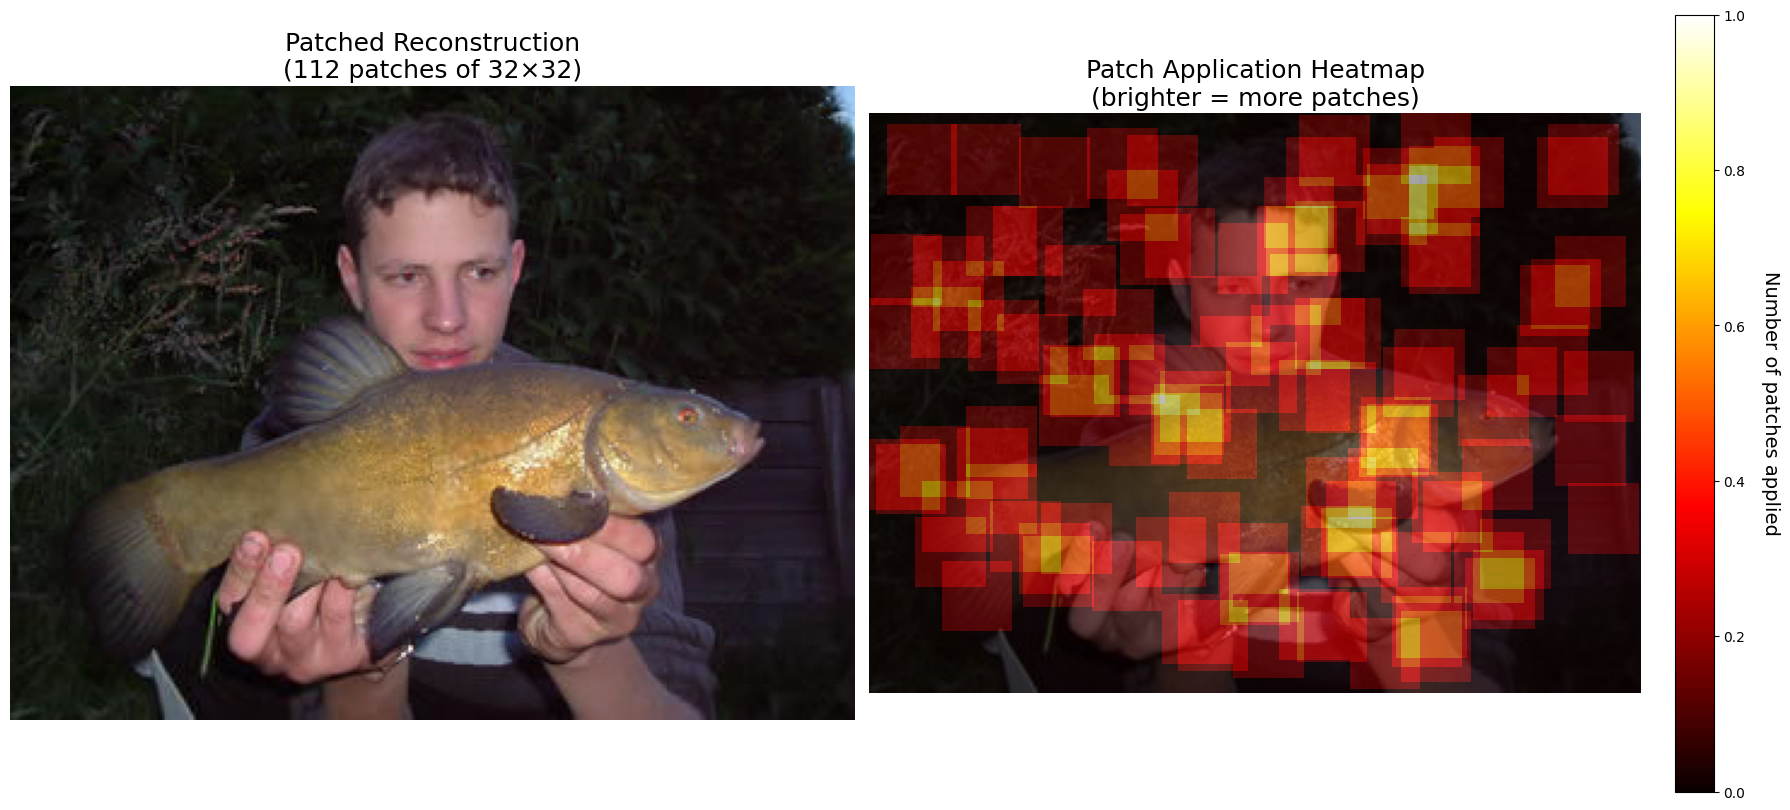

In [36]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Convert to tensors [-1, 1]
real_tensor = torch.from_numpy(real_rgb).permute(2, 0, 1) * 2.0 - 1.0   # [3, H, W]
recon_tensor = torch.from_numpy(recon_rgb).permute(2, 0, 1) * 2.0 - 1.0  # [3, H, W]

_, H, W = real_tensor.shape

# Patch size = 1/8 of the image (rounded down to integer)
patch_size = H // 8   # Since H == W in your case, this works for both
print(f"Image size: {H}×{W} → Patch size: {patch_size}×{patch_size} (1/8)")

# Settings for random number of swaps
min_swaps = 20
max_swaps = 150   # adjust as needed

num_swaps = np.random.randint(min_swaps, max_swaps + 1)
print(f"Applying {num_swaps} random {patch_size}×{patch_size} patches from real → reconstruction")

# Optional: set seed for reproducibility (remove for full randomness)
# np.random.seed(42)
# torch.manual_seed(42)

patched_recon = recon_tensor.clone()
heatmap = torch.zeros(H, W)  # tracks how many times each pixel was patched

# Perform the swaps
for _ in range(num_swaps):
    # Random top-left corner that fits the patch
    i = torch.randint(0, H - patch_size + 1, (1,)).item()
    j = torch.randint(0, W - patch_size + 1, (1,)).item()
    
    # Copy patch from real to recon
    patched_recon[:, i:i+patch_size, j:j+patch_size] = real_tensor[:, i:i+patch_size, j:j+patch_size]
    
    # Update heatmap
    heatmap[i:i+patch_size, j:j+patch_size] += 1

# -----------------------------
# Visualization
# -----------------------------
def denorm(t):
    return ((t.clamp(-1, 1) + 1) / 2).permute(1, 2, 0).cpu().numpy()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

# Patched reconstruction
ax1.imshow(denorm(patched_recon))
ax1.set_title(f"Patched Reconstruction\n({num_swaps} patches of {patch_size}×{patch_size})", fontsize=18)
ax1.axis('off')

# Heatmap overlay
img = denorm(patched_recon)
heatmap_np = heatmap.cpu().numpy()
heatmap_norm = heatmap_np / (heatmap_np.max() + 1e-8)  # normalize safely

ax2.imshow(img)
ax2.imshow(heatmap_norm, cmap='hot', alpha=0.6, interpolation='nearest')
ax2.set_title("Patch Application Heatmap\n(brighter = more patches)", fontsize=18)
ax2.axis('off')

# Colorbar
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='hot'), ax=ax2, fraction=0.046, pad=0.04)
cbar.set_label('Number of patches applied', rotation=270, labelpad=25, fontsize=14)

plt.tight_layout()
plt.show()

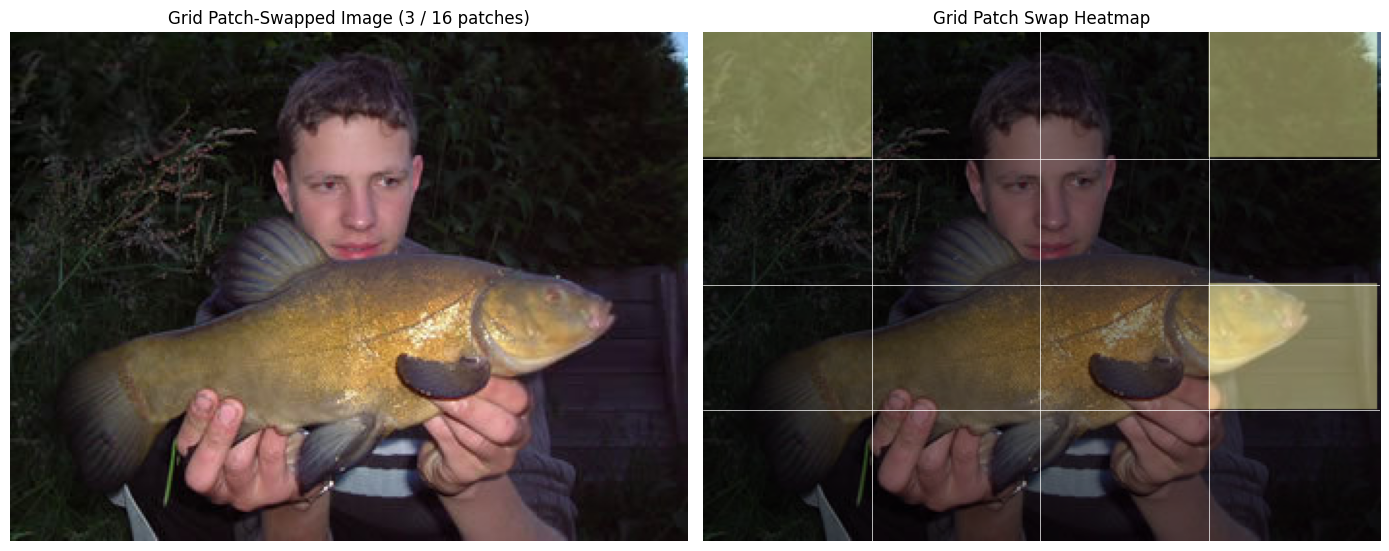

In [47]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt

# -------------------------------------------------
# Inputs
# real_rgb  : H × W × 3, float in [0, 1]
# recon_rgb : H × W × 3, float in [0, 1]
# -------------------------------------------------

# Convert to tensors [-1, 1]
real = torch.from_numpy(real_rgb).permute(2, 0, 1).float() * 2 - 1
recon = torch.from_numpy(recon_rgb).permute(2, 0, 1).float() * 2 - 1

assert real.shape == recon.shape

C, H, W = real.shape

# -------------------------------------------------
# Grid setup
# -------------------------------------------------
GRID = 4                      # 4 × 4 grid
MAX_SWAPS = 8                 # 0 → 8 grid patches

patch_h = H // GRID
patch_w = W // GRID

# -------------------------------------------------
# Choose random grid patches
# -------------------------------------------------
num_swaps = random.randint(0, MAX_SWAPS)

all_cells = [(i, j) for i in range(GRID) for j in range(GRID)]
selected_cells = random.sample(all_cells, k=num_swaps)

# -------------------------------------------------
# Apply grid-based patch swap (recon → real)
# -------------------------------------------------
patched = real.clone()
heatmap = torch.zeros(H, W)

for (gi, gj) in selected_cells:
    top = gi * patch_h
    left = gj * patch_w

    patched[:, top:top+patch_h, left:left+patch_w] = \
        recon[:, top:top+patch_h, left:left+patch_w]

    heatmap[top:top+patch_h, left:left+patch_w] += 1

# -------------------------------------------------
# Visualization
# -------------------------------------------------
def denorm(x):
    return ((x.clamp(-1, 1) + 1) / 2).permute(1, 2, 0).cpu().numpy()

img = denorm(patched)
hm = heatmap.cpu().numpy()

if hm.max() > 0:
    hm = hm / hm.max()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Patched image
ax1.imshow(img)
ax1.set_title(f"Grid Patch-Swapped Image ({num_swaps} / 16 patches)")
ax1.axis("off")

# Heatmap overlay
ax2.imshow(img)
ax2.imshow(hm, cmap="inferno", alpha=0.45)
ax2.set_title("Grid Patch Swap Heatmap")
ax2.axis("off")

# Optional grid lines (debug clarity)
for i in range(1, GRID):
    ax2.axhline(i * patch_h, color="white", lw=0.5)
    ax2.axvline(i * patch_w, color="white", lw=0.5)

plt.tight_layout()
plt.show()
